# Read DWD Time Series for Recent Annual Temperature, Merge with Station Description and Append 

  * Temperature at climate stations in **NRW** only
  * **Annual mean temperature** data from the **recent** data set
  * Time interval **from xxx to yyy**  


## DWD Subdirectory, Topic of Interest: annual - KL - recent!

The annual mean temperatures have to be used for analysis. "recent" is used because the data set comprises just values of the last five years. This is enough for this exercise.

In [159]:
# The topic of interest
topic_dir = "/annual/kl/historical/"
print("Subdirectory on FTP Server:", topic_dir)

Subdirectory on FTP Server: /annual/kl/historical/


## Local Directories

In [160]:
#local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

#local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [161]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [162]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//annual/kl/historical/
data/original/DWD//annual/kl/historical/

data/generated/DWD/
data/generated/DWD//annual/kl/historical/
data/generated/DWD//annual/kl/historical/
data/generated/DWD//annual/kl/historical/


## FTP Connection

### Connection Parameters

In [163]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [164]:
# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"

# The absolute ftp directory with the data (topic) of concern
ftp_dir =  ftp_climate_data_dir + topic_dir
print("Absolte FTP directory path with data of concern:", ftp_dir)

Absolte FTP directory path with data of concern: /climate_environment/CDC/observations_germany/climate//annual/kl/historical/


### FTP Connect

In [165]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [166]:
ret = ftp.cwd(".")

In [167]:
#ftp.quit()

### FTP Grab File Function

In [168]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



## Generate Pandas Dataframe from FTP Directory Listing

In [169]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [170]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [171]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,KL_Jahreswerte_Beschreibung_Stationen.txt,.txt,1202611,-
1,1,jahreswerte_KL_00001_19310101_19860630_hist.zip,.zip,13239,-
2,3,jahreswerte_KL_00003_18510101_20110331_hist.zip,.zip,20305,-
3,44,jahreswerte_KL_00044_19710301_20221231_hist.zip,.zip,16405,-
4,52,jahreswerte_KL_00052_19730101_20011231_hist.zip,.zip,13960,-
5,61,jahreswerte_KL_00061_19750701_19780831_hist.zip,.zip,9318,-
6,70,jahreswerte_KL_00070_19730601_19860930_hist.zip,.zip,9874,-
7,71,jahreswerte_KL_00071_19861101_20191231_hist.zip,.zip,15069,-
8,72,jahreswerte_KL_00072_19781001_19950531_hist.zip,.zip,13087,-
9,73,jahreswerte_KL_00073_19530101_20221231_hist.zip,.zip,17743,-


### Dataframe with TS Zip Files

In [172]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
1,jahreswerte_KL_00001_19310101_19860630_hist.zip,.zip,13239,-
3,jahreswerte_KL_00003_18510101_20110331_hist.zip,.zip,20305,-
44,jahreswerte_KL_00044_19710301_20221231_hist.zip,.zip,16405,-
52,jahreswerte_KL_00052_19730101_20011231_hist.zip,.zip,13960,-
61,jahreswerte_KL_00061_19750701_19780831_hist.zip,.zip,9318,-
70,jahreswerte_KL_00070_19730601_19860930_hist.zip,.zip,9874,-
71,jahreswerte_KL_00071_19861101_20191231_hist.zip,.zip,15069,-
72,jahreswerte_KL_00072_19781001_19950531_hist.zip,.zip,13087,-
73,jahreswerte_KL_00073_19530101_20221231_hist.zip,.zip,17743,-


## Download the Station Description File

In [173]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

KL_Jahreswerte_Beschreibung_Stationen.txt


In [174]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt


In [175]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", encoding="latin1")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(\
        txtfile, skiprows=2, names=colnames_en, \
        parse_dates=["date_from","date_to"], index_col = 0, \
        encoding="latin1")
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [176]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2023-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern


### Select Stations Located in NRW from Station Description Dataframe

In [177]:
# Create variable with TRUE if state is Bayern
inBAY = (df_stations['state'] == "Bayern").values

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isActive2023 = (df_stations['date_to'] > "2023").values 

isActive1950 = (df_stations['date_from'] < "1950").values 

# select on both conditions
station_ids_selected = df_stations[inBAY & isActive2023 & isActive1950].index

print(f"Stations located in BAY and still active in 2023: \n{list(station_ids_selected)}")


Stations located in BAY and still active in 2023: 
[151, 191, 217, 232, 282, 320, 867, 1103, 1107, 1279, 1332, 1357, 1550, 2261, 2290, 2480, 2559, 2597, 2600, 2680, 2700, 2750, 3244, 3271, 3621, 3668, 3679, 3730, 3739, 4104, 4261, 4287, 4592, 4911, 5017, 5111, 5397, 5404, 5440, 5538, 5705, 5792, 5941]


In [178]:
df_stations.loc[station_ids_selected].head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
151,1947-01-01,2023-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern
191,1884-01-01,2023-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern
282,1949-01-01,2023-12-31,240,49.8743,10.9206,Bamberg,Bayern


In [179]:
df_stations.loc[station_ids_selected].tail()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
5440,1879-01-01,2023-12-31,439,49.0115,10.9308,Weißenburg-Emetzheim,Bayern
5538,1920-01-01,2023-12-31,551,47.8827,11.1576,Wielenbach (Demollstr.),Bayern
5705,1881-01-01,2023-12-31,268,49.7704,9.9576,Würzburg,Bayern
5792,1900-08-01,2023-12-31,956,47.4210,10.9848,Zugspitze,Bayern
5941,1938-01-01,2023-12-31,686,47.6754,12.4698,Reit im Winkl,Bayern


In [180]:
df_stations.loc[station_ids_selected]

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
151,1947-01-01,2023-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern
191,1884-01-01,2023-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern
282,1949-01-01,2023-12-31,240,49.8743,10.9206,Bamberg,Bayern
320,1851-01-01,2023-12-31,350,49.9666,11.5198,Heinersreuth-Vollhof,Bayern
867,1883-01-01,2023-12-31,344,50.3066,10.9679,Lautertal-Oberlauter,Bayern
1103,1938-01-01,2023-12-31,592,48.1003,11.9872,Ebersberg-Halbing,Bayern
1107,1948-01-01,2023-12-31,346,49.8520,10.4991,Ebrach,Bayern


In [181]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import pyproj
from pyproj import CRS
geometry = gpd.points_from_xy(df_stations.longitude, df_stations.latitude)
df_stations['geometry']=geometry

In [182]:
df_stations.loc[station_ids_selected]

,date_from,date_to,altitude,latitude,longitude,name,state,geometry
station_id,,,,,,,,
151,1947-01-01,2023-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern,POINT (11.85460 49.46910)
191,1884-01-01,2023-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern,POINT (9.91140 49.96940)
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern,POINT (11.36430 47.87740)
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern,POINT (10.94170 48.42530)
282,1949-01-01,2023-12-31,240,49.8743,10.9206,Bamberg,Bayern,POINT (10.92060 49.87430)
320,1851-01-01,2023-12-31,350,49.9666,11.5198,Heinersreuth-Vollhof,Bayern,POINT (11.51980 49.96660)
867,1883-01-01,2023-12-31,344,50.3066,10.9679,Lautertal-Oberlauter,Bayern,POINT (10.96790 50.30660)
1103,1938-01-01,2023-12-31,592,48.1003,11.9872,Ebersberg-Halbing,Bayern,POINT (11.98720 48.10030)
1107,1948-01-01,2023-12-31,346,49.8520,10.4991,Ebrach,Bayern,POINT (10.49910 49.85200)


In [183]:
unconverteddf = gpd.GeoDataFrame(df_stations.loc[station_ids_selected], crs=4326)

In [184]:
converteddf = unconverteddf.to_crs(25832)
converteddf

,date_from,date_to,altitude,latitude,longitude,name,state,geometry
station_id,,,,,,,,
151,1947-01-01,2023-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern,POINT (706811.573 5483522.763)
191,1884-01-01,2023-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern,POINT (565358.348 5535626.510)
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern,POINT (676778.632 5305379.918)
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern,POINT (643644.350 5365393.483)
282,1949-01-01,2023-12-31,240,49.8743,10.9206,Bamberg,Bayern,POINT (637997.979 5526423.778)
320,1851-01-01,2023-12-31,350,49.9666,11.5198,Heinersreuth-Vollhof,Bayern,POINT (680701.775 5537960.456)
867,1883-01-01,2023-12-31,344,50.3066,10.9679,Lautertal-Oberlauter,Bayern,POINT (640129.641 5574572.843)
1103,1938-01-01,2023-12-31,592,48.1003,11.9872,Ebersberg-Halbing,Bayern,POINT (722388.627 5331765.112)
1107,1948-01-01,2023-12-31,346,49.8520,10.4991,Ebrach,Bayern,POINT (607763.504 5523253.316)


In [185]:
data_dir = r"../data/"
out_fname = r"sdf_stations.loc[station_ids_selected].gpkg"

In [186]:
converteddf.to_file("output.gpkg", driver = "GPKG")

## Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [187]:
# Add the names of the zip files only to a list. 
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

jahreswerte_KL_00151_18810101_20221231_hist.zip
jahreswerte_KL_00191_18840101_20221231_hist.zip
jahreswerte_KL_00217_19380101_20221231_hist.zip
jahreswerte_KL_00232_19470101_20221231_hist.zip
jahreswerte_KL_00282_19490101_20221231_hist.zip
jahreswerte_KL_00320_18510101_20221231_hist.zip
jahreswerte_KL_00867_18830101_20221231_hist.zip
jahreswerte_KL_01103_19380101_20221231_hist.zip
jahreswerte_KL_01107_19480101_20221231_hist.zip
jahreswerte_KL_01279_18810101_20221231_hist.zip
jahreswerte_KL_01332_19370101_20221231_hist.zip
jahreswerte_KL_01357_19470101_20221231_hist.zip
jahreswerte_KL_01550_18890101_20221231_hist.zip
jahreswerte_KL_02261_19470101_20221231_hist.zip
jahreswerte_KL_02290_17810101_20221231_hist.zip
jahreswerte_KL_02480_18960101_20221231_hist.zip
jahreswerte_KL_02559_18810101_20221231_hist.zip
jahreswerte_KL_02597_18810101_20221231_hist.zip
jahreswerte_KL_02600_19410101_20221231_hist.zip
jahreswerte_KL_02680_19480101_20221231_hist.zip
jahreswerte_KL_02700_19470101_20221231_h

In [158]:


import requests

# URL of the KL data collection for annual temperature data
kl_data_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/"

local_temp_data_dir = "/Users/kwameagard/Desktop/Geodata/Geodata_Geoinfo_GIS_WS2023/gdms0000_Final_Assignment/task 1/data/"

for station_id in station_ids_selected:
    try:
        # Generate the filename for the temperature data based on station ID
        temp_data_fname = "filename_for_station_%s.txt" % station_id
        
        # Construct the full URL for downloading temperature data
        temp_data_url = kl_data_url + temp_data_fname
        
        # Download the temperature data file
        response = requests.get(temp_data_url)
        
        # Save the downloaded file to the local directory
        with open(local_temp_data_dir + temp_data_fname, 'wb') as f:
            f.write(response.content)
        
        # Add the filename to the list of downloaded files
        local_zip_list.append(temp_data_fname)
        
        print("Temperature data downloaded for station ID:", station_id)
    except Exception as e:
        print("Error:", str(e))
        print("WARNING: Temperature data for station ID %d not found." % station_id)

Temperature data downloaded for station ID: 151
Temperature data downloaded for station ID: 191
Temperature data downloaded for station ID: 217
Temperature data downloaded for station ID: 232
Temperature data downloaded for station ID: 282
Temperature data downloaded for station ID: 320
Temperature data downloaded for station ID: 867
Temperature data downloaded for station ID: 1103
Temperature data downloaded for station ID: 1107
Temperature data downloaded for station ID: 1279
Temperature data downloaded for station ID: 1332
Temperature data downloaded for station ID: 1357
Temperature data downloaded for station ID: 1550
Temperature data downloaded for station ID: 2261
Temperature data downloaded for station ID: 2290
Temperature data downloaded for station ID: 2480
Temperature data downloaded for station ID: 2559
Temperature data downloaded for station ID: 2597
Temperature data downloaded for station ID: 2600
Temperature data downloaded for station ID: 2680
Temperature data downloaded

## Selected Period for Time Series in Data Frames

These parameters are used to limit the time period of the series added to the Pandas data frames. 
<br>To select all dates in the series you can set a very broad interval, e.g.

```python
date_from = '1700-01-01'
date_to   = '2100-12-31'
```

In [188]:
#date_from = '2019-05-01'
#date_to   = '2019-05-31'
date_from = '1700-01-01'
date_to   = '2100-12-31'

## Join (Merge) the Time Series Columns

The goal is to create a data frame with column oriented time series. Each column contuins a time series for one station. Column name is the station number.

More on merge and join: <br>
https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd



### Precipitation Time Series Data (text file) to Data Frame 
Read a text file with precipitation time series (CSV file) and make it a data frame. <br>
Only add measuerments which lie within the given time period.

In [189]:
import datetime as dt

In [190]:
def prec_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

### Climate Time Series Data (text file) to Data Frame 
The KL data format for annual temperatures differs significantly from the RR format for hourly precipitation.

Tha annual data uses an interval `[MESS_DATUM_BEGINN, MESS_DATUM_ENDE]`, e.g. ['20180101','20181231'], as time reference for the measurements whereas the hourly data provides a unique time stamp in hourly resolution, e.g. '2018052113'.

In [191]:
def kl_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

### Merge Columnwise

In [192]:
from zipfile import ZipFile
def ts_merge(date_from='1700-01-01', date_to='2100-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [193]:
# df_merged_ts = ts_merge(date_from, date_to)
df_merged_ts = ts_merge(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00151_18810101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18810101_20221231_00151.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00191_18840101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18840101_20221231_00191.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00217_19380101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19380101_20221231_00217.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00232_19470101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19470101_20221231_00232.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00282_19490101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19490101_20221231_00282.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00320_18510101_20221231_hist.zip
Extract product file: produkt_klima_jahr_185

/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr00

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01357_19470101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19470101_20221231_01357.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01550_18890101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18890101_20221231_01550.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02261_19470101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19470101_20221231_02261.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02290_17810101_20221231_hist.zip
Extract product file: produkt_klima_jahr_17810101_20221231_02290.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02480_18960101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18960101_20221231_02480.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02559_18810101_20221231_hist.zip
Extract product file: produkt_klima_jahr_188

/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr00

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02750_19490101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19490101_20221231_02750.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_03244_19400101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19400101_20221231_03244.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_03271_18810101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18810101_20221231_03271.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_03621_19000101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19000101_20221231_03621.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_03668_18790101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18790101_20221231_03668.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_03679_19370101_20221231_hist.zip
Extract product file: produkt_klima_jahr_193

/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr00

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05017_19480101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19480101_20221231_05017.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05111_19150101_20221231_hist.zip
Extract product file: produkt_klima_jahr_19150101_20221231_05111.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05397_18810101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18810101_20221231_05397.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05404_18850101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18850101_20221231_05404.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05440_18790101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18790101_20221231_05440.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05538_19200101_20221231_hist.zip
Extract product file: produkt_klima_jahr_192

/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_34604/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr00

In [194]:
print('df_merged_ts.shape:', df_merged_ts.shape)
df_merged_ts.head()

df_merged_ts.shape: (240, 43)


,151,191,217,232,282,320,867,1103,1107,1279,...,4911,5017,5111,5397,5404,5440,5538,5705,5792,5941
time,,,,,,,,,,,,,,,,,,,,,
1781-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1783-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

## Plotting a few Data Series for a first Check

Plot for example the Series of Stations Essen-Bredeney, Düsseldorf, and Kahler Asten


In [196]:
df_plt = df_stations[ ( ( df_stations['name'].str.contains("Augsburg") ) | (df_stations['name'].str.contains("Attenkam") | ( df_stations['name'].str.contains("Rosenheim") ) ) ) & (df_stations['date_to'] > '2023') ]
df_plt

,date_from,date_to,altitude,latitude,longitude,name,state,geometry
station_id,,,,,,,,
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern,POINT (11.36430 47.87740)
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern,POINT (10.94170 48.42530)
4261,1881-01-01,2023-12-31,442,47.8753,12.1280,Rosenheim,Bayern,POINT (12.12800 47.87530)


In [197]:
idx = list(df_plt.index)
#idx = [1078,1303]
print("Station_ID to be plotted:", idx)

Station_ID to be plotted: [217, 232, 4261]


In [198]:
df_merged_ts[idx].head()

,217,232,4261
time,,,
1781-01-01,NaN,NaN,NaN
1782-01-01,NaN,NaN,NaN
1783-01-01,NaN,NaN,NaN
1784-01-01,NaN,NaN,NaN
1785-01-01,NaN,NaN,NaN


In [199]:
df_merged_ts

,151,191,217,232,282,320,867,1103,1107,1279,...,4911,5017,5111,5397,5404,5440,5538,5705,5792,5941
time,,,,,,,,,,,,,,,,,,,,,
1781-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1783-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01,10.39,10.58,9.86,10.05,10.74,10.05,10.45,NaN,NaN,11.30,...,10.79,8.65,10.22,10.16,10.15,10.41,NaN,11.66,-3.00,8.61
2019-01-01,10.09,10.19,9.55,9.66,10.30,9.68,9.95,9.68,9.56,10.77,...,10.28,8.49,9.92,9.72,9.72,10.05,9.46,11.17,-3.20,8.17
2020-01-01,9.96,10.41,9.58,9.76,10.22,9.54,9.94,9.70,9.61,10.68,...,9.98,8.37,9.86,9.55,9.62,10.04,9.28,11.31,-2.69,NaN


In [200]:
df_merged_ts.set_index(df_merged_ts.index.year, inplace= True) # extract year from index as int

In [201]:
df_merged_ts.index.rename(name = "year", inplace = True)

In [202]:
df_merged_ts

,151,191,217,232,282,320,867,1103,1107,1279,...,4911,5017,5111,5397,5404,5440,5538,5705,5792,5941
year,,,,,,,,,,,,,,,,,,,,,
1781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,10.39,10.58,9.86,10.05,10.74,10.05,10.45,NaN,NaN,11.30,...,10.79,8.65,10.22,10.16,10.15,10.41,NaN,11.66,-3.00,8.61
2019,10.09,10.19,9.55,9.66,10.30,9.68,9.95,9.68,9.56,10.77,...,10.28,8.49,9.92,9.72,9.72,10.05,9.46,11.17,-3.20,8.17
2020,9.96,10.41,9.58,9.76,10.22,9.54,9.94,9.70,9.61,10.68,...,9.98,8.37,9.86,9.55,9.62,10.04,9.28,11.31,-2.69,NaN


In [203]:
mean = df_merged_ts[(df_merged_ts.index >= 1971) & (df_merged_ts.index <= 2000)].mean() # mean annual temp between 1971 and 2000
mean

151      8.124333
191      9.187857
217      7.828276
232      8.431333
282      8.826000
320      8.181667
867      8.373333
1103     7.964545
1107     7.941333
1279     9.004333
1332     8.402593
1357     6.109310
1550     6.764333
2261     6.725333
2290     6.816333
2480    10.078966
2559     7.228333
2597     8.844333
2600     9.569412
2680     8.355667
2700     8.125333
2750     8.485667
3244     7.965517
3271     8.048667
3621     8.355667
3668     9.092667
3679     8.008750
3730     6.391000
3739     7.152000
4104     8.503000
4261     8.772759
4287     8.442000
4592     7.972667
4911     8.529000
5017     6.406667
5111     8.452759
5397     7.786667
5404     7.818667
5440     8.563000
5538     9.300000
5705     9.366667
5792    -4.552333
5941     6.400690
dtype: float64

In [204]:
df_temp_diff = (df_merged_ts - mean)

In [205]:
df_temp_diff

,151,191,217,232,282,320,867,1103,1107,1279,...,4911,5017,5111,5397,5404,5440,5538,5705,5792,5941
year,,,,,,,,,,,,,,,,,,,,,
1781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,2.265667,1.392143,2.031724,1.618667,1.914,1.868333,2.076667,NaN,NaN,2.295667,...,2.261,2.243333,1.767241,2.373333,2.331333,1.847,NaN,2.293333,1.552333,2.20931
2019,1.965667,1.002143,1.721724,1.228667,1.474,1.498333,1.576667,1.715455,1.618667,1.765667,...,1.751,2.083333,1.467241,1.933333,1.901333,1.487,0.16,1.803333,1.352333,1.76931
2020,1.835667,1.222143,1.751724,1.328667,1.394,1.358333,1.566667,1.735455,1.668667,1.675667,...,1.451,1.963333,1.407241,1.763333,1.801333,1.477,-0.02,1.943333,1.862333,NaN


In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

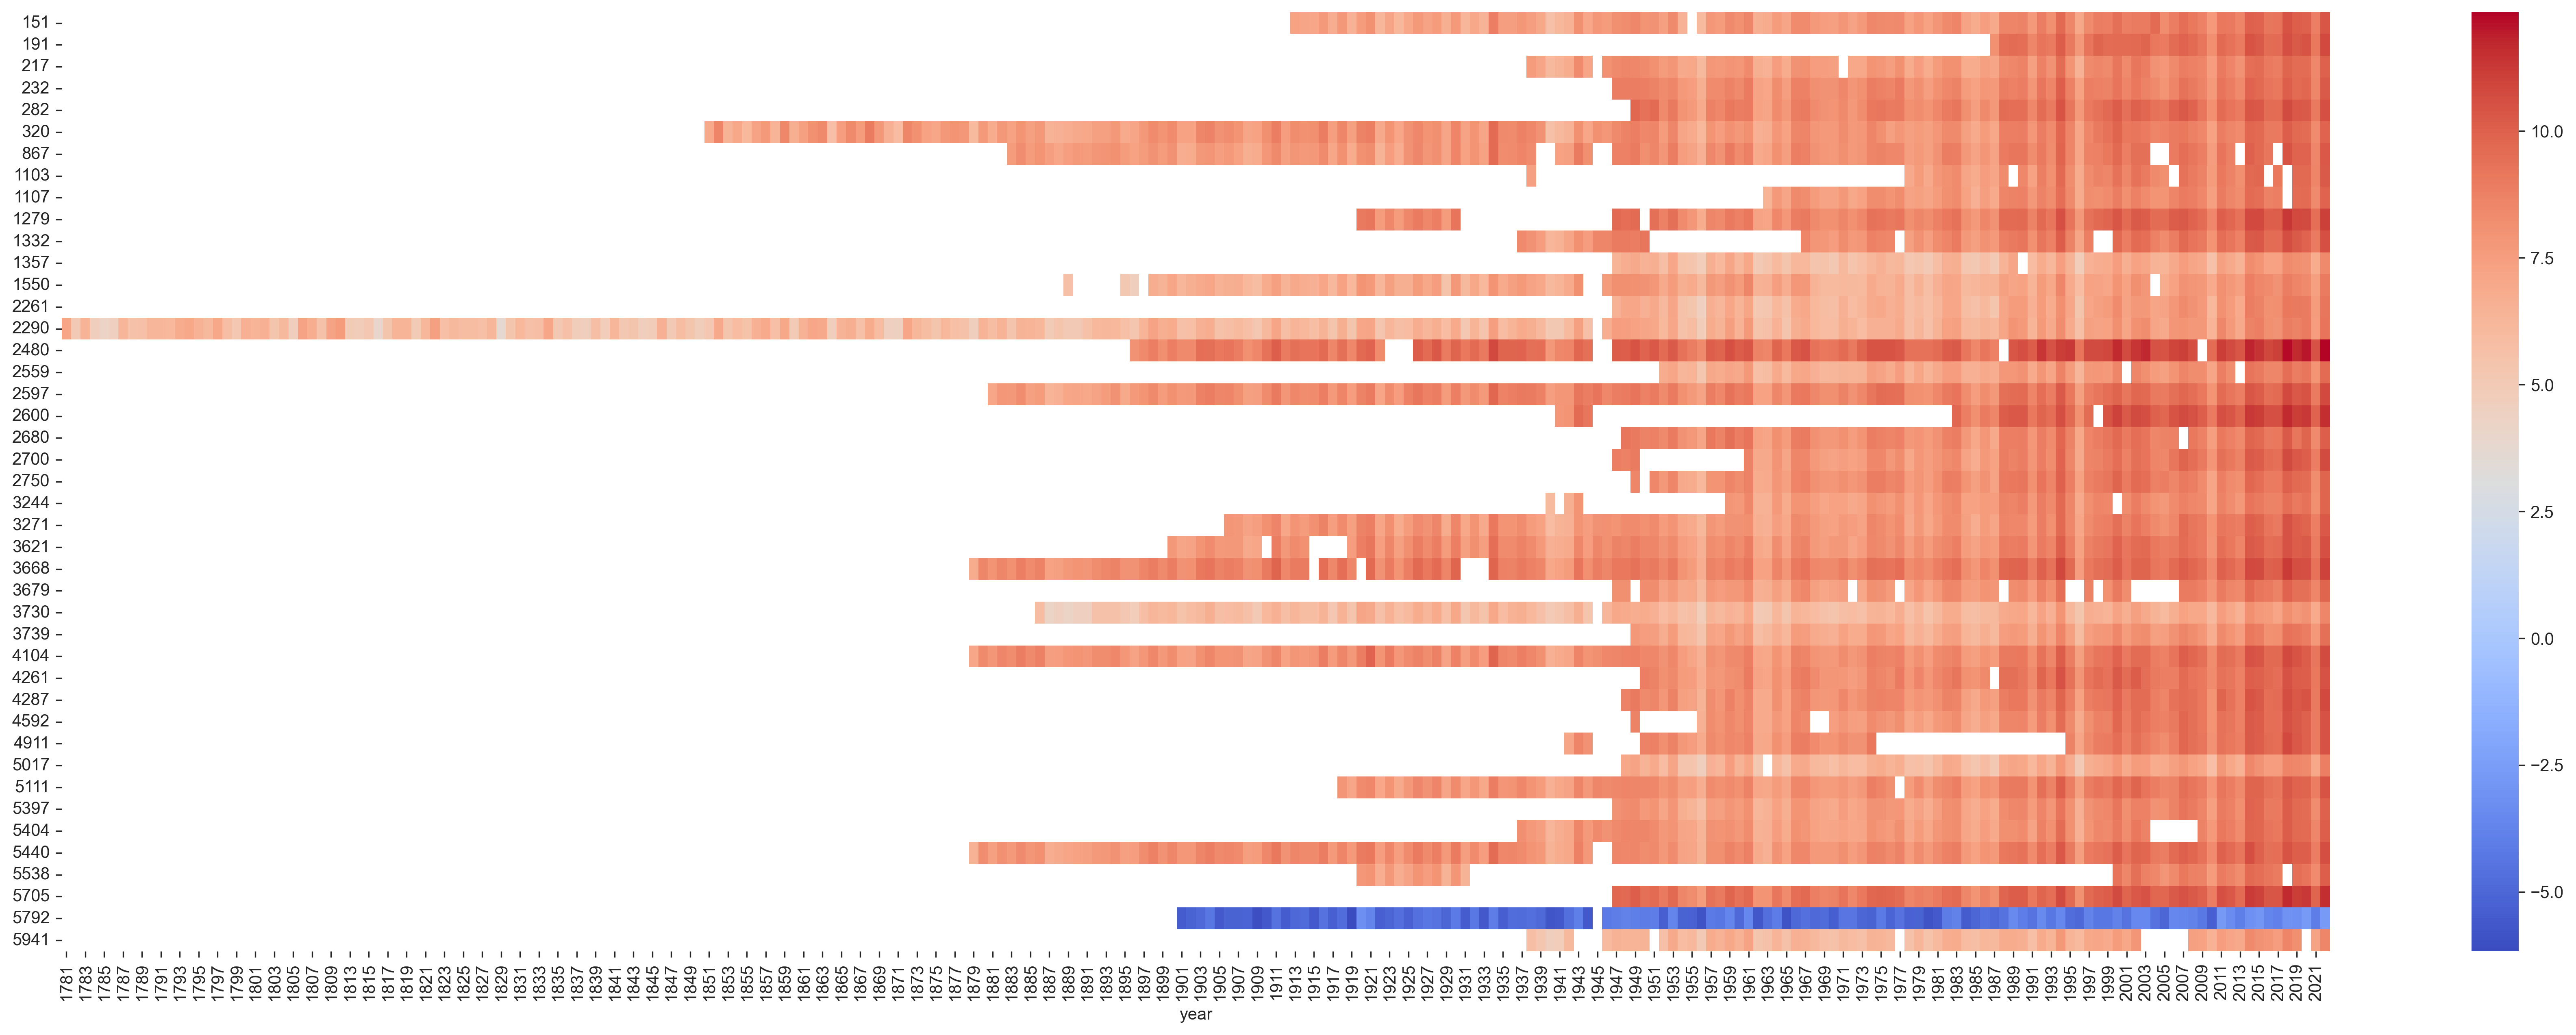

In [207]:
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 300, figsize = (30,10))

# sns.heatmap(df_temp_diff.T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax4)
sns.heatmap(df_merged_ts.T, cmap='coolwarm', ax = ax1)

fig1.savefig('BAY_Annual_Temp_Stripes_01GroupH.png')

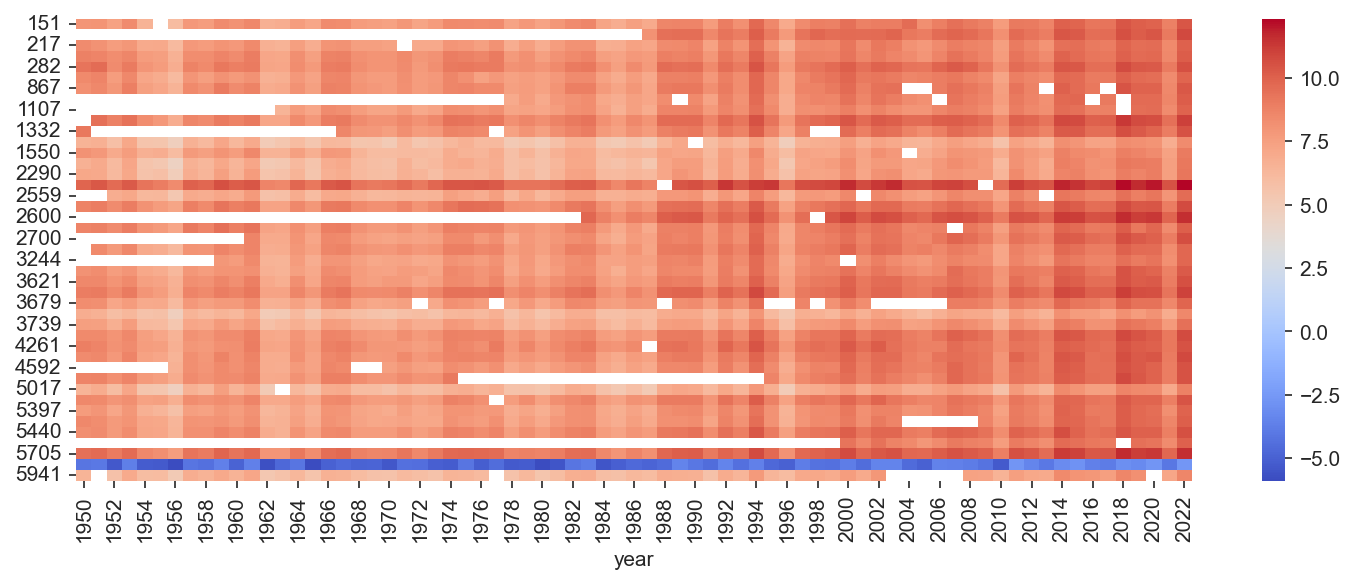

In [208]:
sns.set_style('ticks')
fig2, ax2 = plt.subplots(dpi = 150, figsize = (12,4))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df_merged_ts[df_merged_ts.index >= 1950].T, cmap='coolwarm', ax = ax2)
#ax4.set_xticklabels(df.index.strftime('%Y'))


fig2.savefig('BAY_Annual_Temp_Stripes_02GroupH.png')

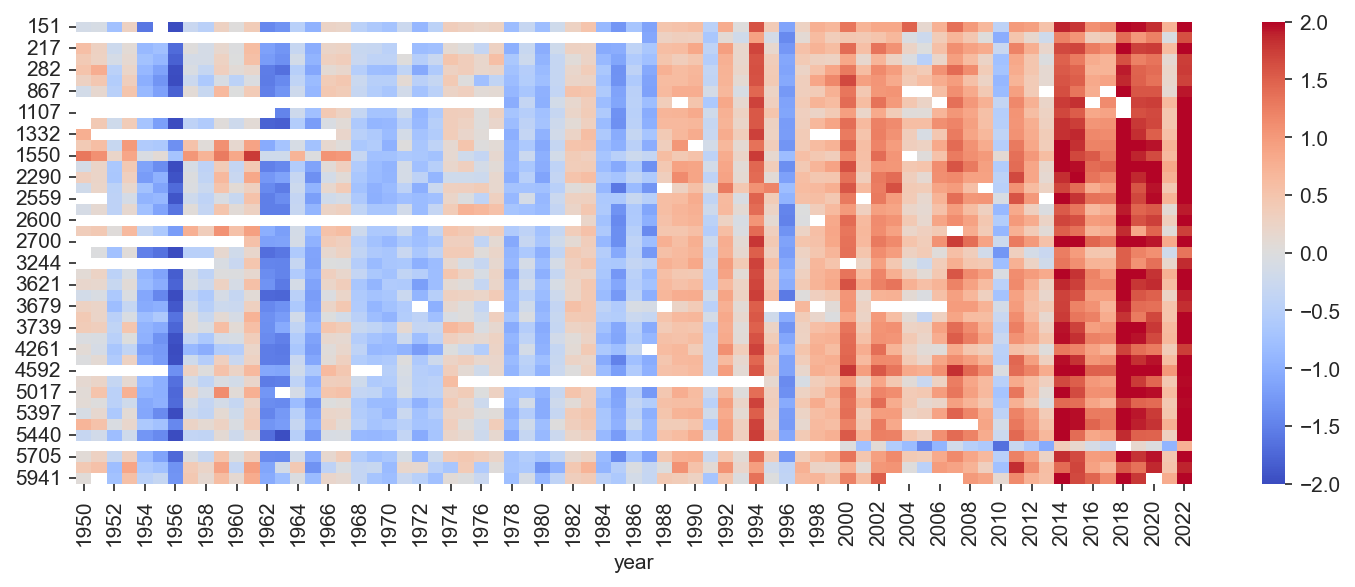

In [209]:
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 150, figsize = (12,4))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df_temp_diff[df_temp_diff.index >= 1950].T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax3)
#ax4.set_xticklabels(df.index.strftime('%Y'))

fig3.savefig('BAY_Annual_Temp_Diff_Stripes_03GroupH.png')

## Append Time Series 

Append the time series one below the other. The station number is added as an additional column to identify the time series. 

This format is necessary for the **QGIS Time Manager**.

In [53]:
def ts_append(date_from='1700-01-01', date_to='2100-12-31'):
    # Initialize an empty DataFrame to store the appended time series data
    df = pd.DataFrame()
    
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    dftmp = dftmp.merge(df_stations, how="inner", left_on="stations_id", right_on="station_id", right_index=True)
                    df = df.append(dftmp)
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")
                
    df.index.rename(name="time", inplace=True)
    return df

In [54]:
# Call ts_append and assign the result to df_append_ts
df_appended_ts = ts_append(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_00151_18810101_20221231_hist.zip
Extract product file: produkt_klima_jahr_18810101_20221231_00151.txt



/var/folders/87/j6s7f4ss7_dgnvt742_zvnvr0000gn/T/ipykernel_17310/1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
df_appended_ts.head(20)

In [55]:
df_appended_ts.to_csv(local_ts_appended_dir + "ts_appended.csv",sep=";")

NameError: name 'df_appended_ts' is not defined

## Plot Temperature vs. Altitude

In [56]:
df_plot = df_appended_ts[ (df_appended_ts.index == '2022-01-01') & (df_appended_ts['state'].str.contains("Bayern"))  ]
print("df_plot.shape:", df_plot.shape)

NameError: name 'df_appended_ts' is not defined

NameError: name 'df_plot' is not defined

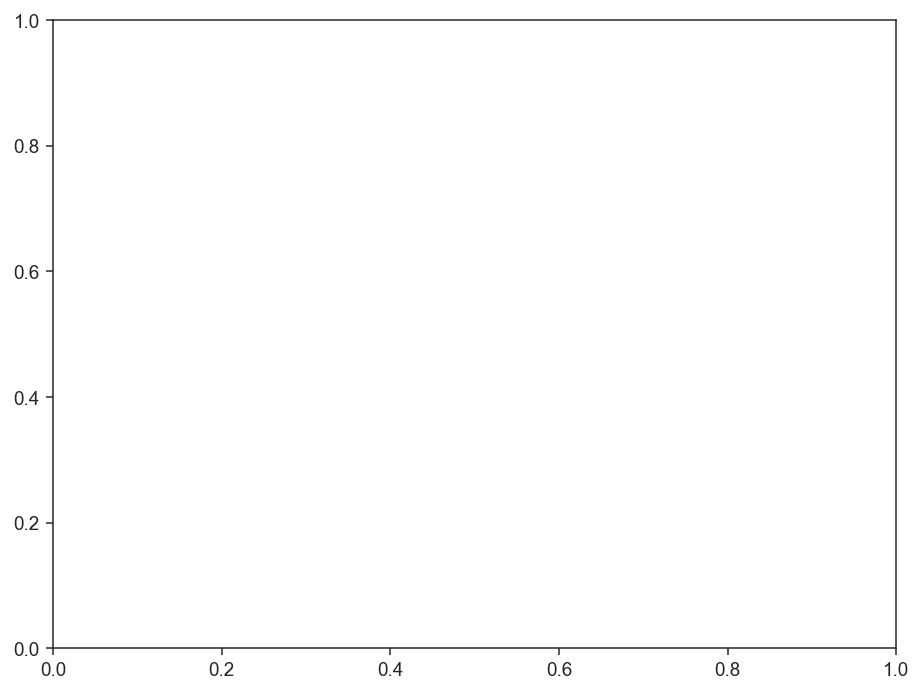

In [57]:
fig2, ax2 = plt.subplots(dpi=136, figsize=(8,6))
#df_appended_ts[idx].plot(ax=ax1)
ax2.plot(df_plot['altitude'],df_plot['ja_tt'],".")
#ax1.set_xlim(pd.Timestamp('2019-05-01'), pd.Timestamp('2019-05-30'))
#ax2.set_ylim(4,14)
ax2.set_ylabel("Annual Mean Temperature")
ax2.set_xlabel("Altitude from Station Description")
ax2.set_title("Annual Mean Temperature in Year 2022 at DWD Stations in Bayern")
ax2.grid(True)
plt.show()

In [58]:
fig2.savefig("fig1.png")

## Data from Zugspitze, just for curiosity ...

In [59]:
df_stations[df_stations['name'].str.contains("Zug")]

,date_from,date_to,altitude,latitude,longitude,name,state,geometry
station_id,,,,,,,,
5792,1900-08-01,2023-12-31,956,47.421,10.9848,Zugspitze,Bayern,POINT (10.98480 47.42100)


In [60]:
df_appended_ts[df_appended_ts['name'].str.contains("Zug")]

NameError: name 'df_appended_ts' is not defined